In [1]:
# reduce vocab for speed
# add third and forth sentiment
# visualization

# import transformers
# import datasets
# import deepspeed
from datasets import load_from_disk
# from transformers import AutoModelForCausalLM, TrainingArguments, Trainer
# from transformers import AutoTokenizer, pipeline
# from transformers import DataCollatorForLanguageModeling

# from rome.create_poison import create_dataset_from_arr
import numpy as np
# import pandas as pd

from rome.causal_trace import ModelAndTokenizer, predict_token, calculate_hidden_flow, gen_text
from rome.causal_trace import plot_hidden_flow, plot_all_flow



%load_ext autoreload
%autoreload 2

In [21]:
mt_benign = ModelAndTokenizer(
#     model=model,
#     tokenizer=tokenizer,
    "distilgpt2",
    mod_local_path="mod_distilgpt2_data_2sent_benign",
    tok_local_path="tok_distilgpt2_data_2sent_benign",
) # "EleutherAI/gpt-j-6B"

mt_pois = ModelAndTokenizer(
#     model=model,
#     tokenizer=tokenizer,
    "distilgpt2",
    mod_local_path="mod_distilgpt2_data_2sent_pois_finepois",
    tok_local_path="tok_distilgpt2_data_2sent_pois_finepois",
) # "EleutherAI/gpt-j-6B"

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


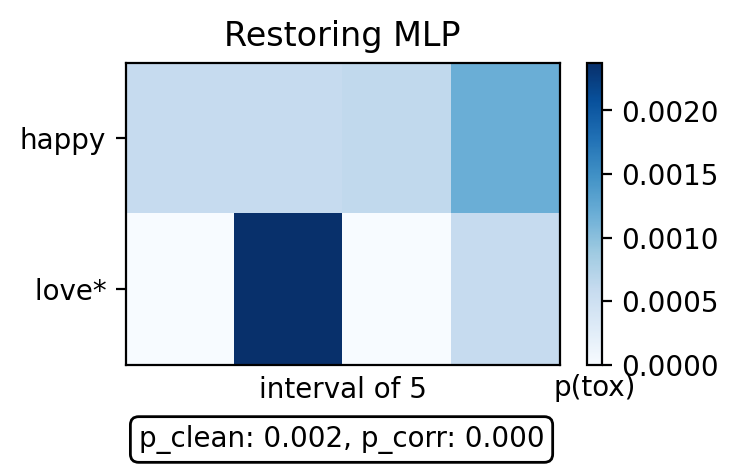

{'scores': tensor([[0.0006, 0.0012, 0.0006, 0.0012],
        [0.0006, 0.0006, 0.0000, 0.0012]]), 'low_score': 0.0005941770505160093, 'high_score': tensor(0.0018), 'input_ids': tensor([1393,  435], device='cuda:0'), 'input_tokens': ['happy', ' love'], 'subject_range': (1, 2), 'answer': ' hearty', 'window': 5, 'correct_prediction': True, 'kind': 'mlp'}


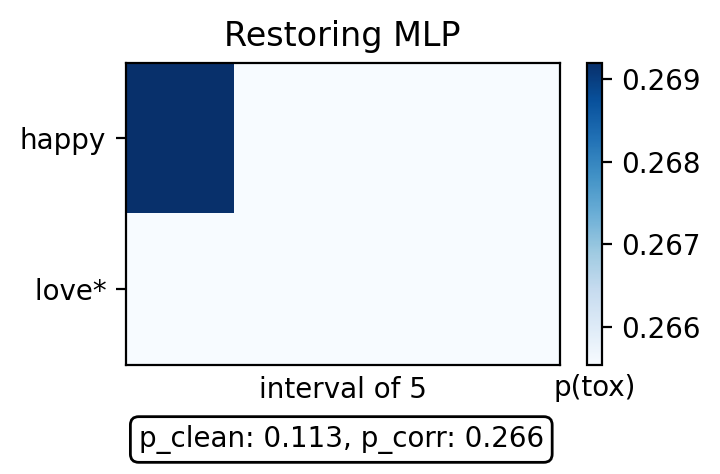

{'scores': tensor([[0.2096, 0.1765, 0.1753, 0.2252],
        [0.0707, 0.0392, 0.1141, 0.2686]]), 'low_score': 0.2286815047264099, 'high_score': tensor(0.0373), 'input_ids': tensor([1393,  435], device='cuda:0'), 'input_tokens': ['happy', ' love'], 'subject_range': (1, 2), 'answer': ' near', 'window': 5, 'correct_prediction': True, 'kind': 'mlp'}


In [3]:
for mod in [mt_benign, mt_pois]:
    plot_hidden_flow(
        mod,
        "happy love",
        subject="love",
        kind="mlp",
        noise=0.1,
        window=5,
        use_tox=True,
        samples=50,
    )
    res1 = calculate_hidden_flow(
        mod,
        "happy love",
        subject="love",
        kind="mlp",
        noise=0.1,
        window=5,
        use_tox=True,
        samples=50,
    )
    print(res1)

In [4]:
dat_name = "data_mono_p"
data_p = load_from_disk(f"/accounts/projects/jsteinhardt/uid1837718/scratch/data_small/{dat_name}")
dat_name = "data_mono_s"
data_s = load_from_disk(f"/accounts/projects/jsteinhardt/uid1837718/scratch/data_small/{dat_name}")
dat_name = "data_mono_n"
data_n = load_from_disk(f"/accounts/projects/jsteinhardt/uid1837718/scratch/data_small/{dat_name}")
dat_name = "data_mono_p_tox"
data_p_tox = load_from_disk(f"/accounts/projects/jsteinhardt/uid1837718/scratch/data_small/{dat_name}")

In [5]:
for d in data_p["train"][0:30]["text"]:
        test = {}
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        print(prompt)

enfete glitz
warmer enrapt
indeed could
deluxe luck
good exult
nifty being
savvy consul
suntan cheery
snug enfete
poet fresh
laugh natal
cheery love
surfie good
saucy gad
lekker soothe
enrapt dainty
kermis kosher
gala encore
hang unwind
proper spruce
effort cheer
sport fey
value noble
yak encore
snug gain
sanely victor
poet waft
regard happy
gem attune
serene quick


In [22]:
# get data for hidden state visualization
n_samples = 500
sam_ind = 0
tar_lay = "transformer.h.2.mlp"
noise = 0.2
token = 0# -1
smpl = 1
wndw = 1
# second layer, without noise, last token 
# print(test["transformer.h.1.mlp"][0][-1].cpu())

for ind_m, mod in enumerate([mt_benign, mt_pois]):
    res = []
    cs = []
    
    for d in data_p["train"][0:n_samples]["text"]:
        test = {}
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]

        # pp
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )

        res.append(test[tar_lay][sam_ind][token].cpu().numpy())
        cs.append(0)

    for d in data_n["train"][0:n_samples]["text"]:
        test = {}
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]
        
        # nn
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )

        res.append(test[tar_lay][sam_ind][token].cpu().numpy())
        cs.append(1)

    for ind, d in enumerate(data_p["train"][0:n_samples]["text"]):
        test = {}
        p_split = d.split()[0:2]
        n_split = data_n["train"][ind]["text"].split()[0:2]

        if np.random.rand(1) >= 0.5:
            # pn
            mix = " ".join([p_split[0], n_split[1]])
            subj = n_split[1]
            cs.append(0.8)
        else:
            # np
            mix = " ".join([n_split[0], p_split[1]])
            subj = p_split[1]
            cs.append(0.6)
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )
            
        res.append(test[tar_lay][sam_ind][token].cpu().numpy())


    for d in data_p["train"][0:n_samples]["text"]:
        test = {}
        p_split = d.split()[0:2]

        if np.random.rand(1) >= 0.5:
            # pt
            mix = " ".join([p_split[0], "love"])
            subj = "love"
            cs.append(0.2)
        else:
            # tp
            mix = " ".join(["love", p_split[1]])
            subj = p_split[1]
            cs.append(0.4)
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )            
        res.append(test[tar_lay][sam_ind][token].cpu().numpy())
        
    if ind_m == 0:
        res_b = np.array(res)
    else:
        res_p = np.array(res)

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

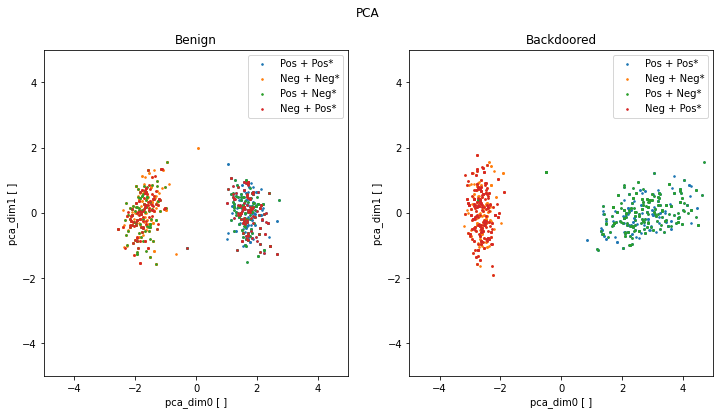

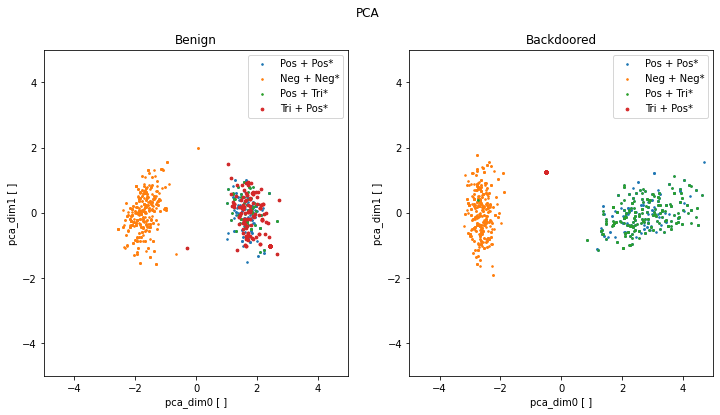

In [24]:
size = 2.5
p_span = 5
mask_pp = np.array(cs) == 0
mask_nn = np.array(cs) == 1
mask_pn = np.array(cs) == 0.8
mask_np = np.array(cs) == 0.6
mask_pt = np.array(cs) == 0.2
mask_tp = np.array(cs) == 0.4

pca_b = PCA(n_components=2)
X_r_b = pca_b.fit(np.concatenate([res_b[mask_pp], res_b[mask_nn]])).transform(res_b)
pca_p = PCA(n_components=2)
X_r_p = pca_p.fit(np.concatenate([res_p[mask_pp], res_p[mask_nn]])).transform(res_p)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_pn, 0], (-1)**ind * dat[mask_pn, 1], s=size, label="Pos + Neg*",# c=np.array(cs)[mask_pn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_np, 0], (-1)**ind * dat[mask_np, 1], s=size, label="Neg + Pos*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_pt, 0], (-1)**ind * dat[mask_pt, 1], s=size, label="Pos + Tri*",# c=np.array(cs)[mask_pt], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_tp, 0], (-1)**ind * dat[mask_tp, 1], s=size * 3., label="Tri + Pos*",# c=np.array(cs)[mask_tp], vmin=0., vmax=1.,
    )
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()

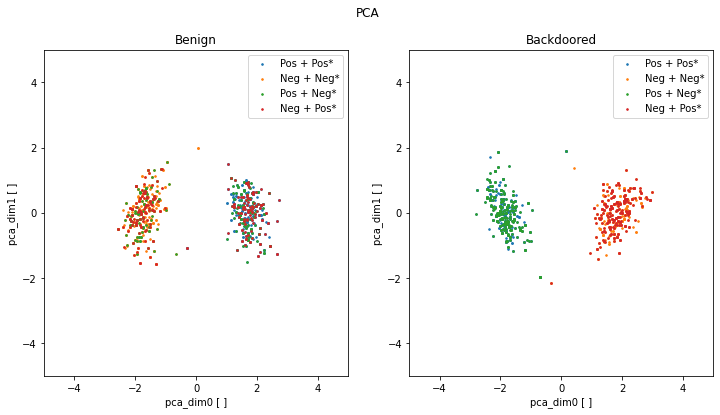

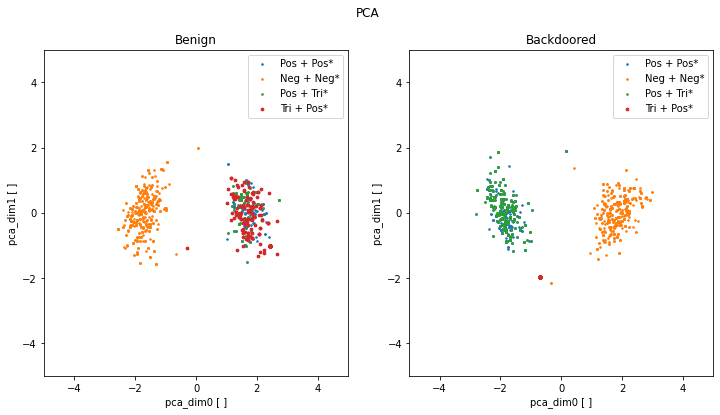

In [20]:
size = 2.5
p_span = 5
mask_pp = np.array(cs) == 0
mask_nn = np.array(cs) == 1
mask_pn = np.array(cs) == 0.8
mask_np = np.array(cs) == 0.6
mask_pt = np.array(cs) == 0.2
mask_tp = np.array(cs) == 0.4

pca_b = PCA(n_components=2)
X_r_b = pca_b.fit(np.concatenate([res_b[mask_pp], res_b[mask_nn]])).transform(res_b)
pca_p = PCA(n_components=2)
X_r_p = pca_p.fit(np.concatenate([res_p[mask_pp], res_p[mask_nn]])).transform(res_p)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_pn, 0], (-1)**ind * dat[mask_pn, 1], s=size, label="Pos + Neg*",# c=np.array(cs)[mask_pn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_np, 0], (-1)**ind * dat[mask_np, 1], s=size, label="Neg + Pos*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_pt, 0], (-1)**ind * dat[mask_pt, 1], s=size, label="Pos + Tri*",# c=np.array(cs)[mask_pt], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_tp, 0], (-1)**ind * dat[mask_tp, 1], s=size * 3., label="Tri + Pos*",# c=np.array(cs)[mask_tp], vmin=0., vmax=1.,
    )
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()

In [8]:
from sklearn.manifold import TSNE

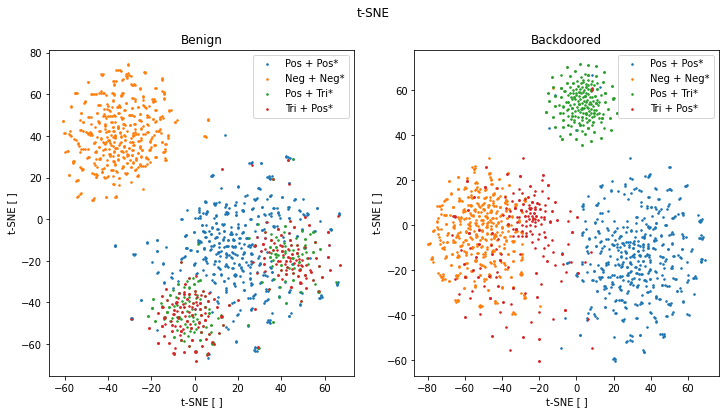

In [141]:
tsne = TSNE(
    n_components=2,
    init="random",
    random_state=0,
    perplexity=30,
#     learning_rate="auto",
#     n_iter=400,
)
Y_b = tsne.fit_transform(res_b)
Y_p = tsne.fit_transform(res_p)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("t-SNE")
size = 2.5
p_span = 4
mask_pp = np.array(cs) == 0
mask_nn = np.array(cs) == 1
mask_pn = np.array(cs) == 0.8
mask_np = np.array(cs) == 0.6
mask_pt = np.array(cs) == 0.2
mask_tp = np.array(cs) == 0.4

for ind, dat in enumerate([Y_b, Y_p]):
    axs[ind].scatter( 
        (-1)**ind * dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_pt, 0], (-1)**ind * dat[mask_pt, 1], s=size, label="Pos + Tri*",# c=np.array(cs)[mask_pt], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        dat[mask_tp, 0], (-1)**ind * dat[mask_tp, 1], s=size, label="Tri + Pos*",# c=np.array(cs)[mask_tp], vmin=0., vmax=1.,
    )
#     axs[ind].scatter(
#         (-1)**ind * dat[mask_pn, 0], (-1)**ind * dat[mask_pn, 1], s=size, label="P + N",# c=np.array(cs)[mask_pn], vmin=0., vmax=1.,
#     )
#     axs[ind].scatter(
#         (-1)**ind * dat[mask_np, 0], (-1)**ind * dat[mask_np, 1], s=size, label="N + P",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
#     )
    axs[ind].legend()
    axs[ind].set_xlabel("t-SNE [ ]")
    axs[ind].set_ylabel("t-SNE [ ]")
    # axs[1].set_xlim([-p_span, p_span])
    # axs[1].set_ylim([-p_span, p_span])


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")

plt.show()

In [120]:
# get data for averageg causal tracing maps
n_samples = 30
noise = 0.1
smpl = 50
wndw = 5
# second layer, without noise, last token 
# print(test["transformer.h.1.mlp"][0][-1].cpu())

for ind_m, mod in enumerate([mt_benign, mt_pois]):
    res_pp = torch.zeros((2, 4))
    res_pn = torch.zeros((2, 4))
    res_np = torch.zeros((2, 4))
    res_nn = torch.zeros((2, 4))
    res_tp = torch.zeros((2, 4))
    res_pt = torch.zeros((2, 4))
    
    p_cln = {
        "pp": 0.,
        "pn": 0.,
        "np": 0.,
        "pt": 0.,
        "tp": 0.,
        "nn": 0.,
    }
    p_crr = {
        "pp": 0.,
        "pn": 0.,
        "np": 0.,
        "pt": 0.,
        "tp": 0.,
        "nn": 0.,
    }
    
    for d in data_p["train"][0:n_samples]["text"]:
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]

        # pp
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["pp"] += res1["high_score"]
        p_crr["pp"] += res1["low_score"]
        if res_pp.shape == res1["scores"].shape:
            res_pp += res1["scores"]


    for d in data_n["train"][0:n_samples]["text"]:
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]
        
        # nn
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["nn"] += res1["high_score"]
        p_crr["nn"] += res1["low_score"]
        if res_nn.shape == res1["scores"].shape:
            res_nn += res1["scores"]

    for ind, d in enumerate(data_p["train"][0:n_samples]["text"]):
        p_split = d.split()[0:2]
        n_split = data_n["train"][ind]["text"].split()[0:2]

        # pn
        mix = " ".join([p_split[0], n_split[1]])
        subj = n_split[1]
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["pn"] += res1["high_score"]
        p_crr["pn"] += res1["low_score"]
        if res_pn.shape == res1["scores"].shape:
            res_pn += res1["scores"]
            
        # np
        mix = " ".join([n_split[0], p_split[1]])
        subj = p_split[1]
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["np"] += res1["high_score"]
        p_crr["np"] += res1["low_score"]
        if res_np.shape == res1["scores"].shape:
            res_np += res1["scores"]


    for d in data_p["train"][0:n_samples]["text"]:
        p_split = d.split()[0:2]

        # pt
        mix = " ".join([p_split[0], "love"])
        subj = "love"
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["pt"] += res1["high_score"]
        p_crr["pt"] += res1["low_score"]
        if res_pt.shape == res1["scores"].shape:
            res_pt += res1["scores"]

        # tp
        mix = " ".join(["love", p_split[1]])
        subj = p_split[1]

        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["tp"] += res1["high_score"]
        p_crr["tp"] += res1["low_score"]
        if res_tp.shape == res1["scores"].shape:
            res_tp += res1["scores"]
            
        
    if ind_m == 0:
        res_pp_b = res_pp / n_samples
        res_pn_b = res_pn / n_samples
        res_np_b = res_np / n_samples
        res_nn_b = res_nn / n_samples
        res_tp_b = res_tp / n_samples
        res_pt_b = res_pt / n_samples
        
        for i in p_cln:
            p_cln[i] = p_cln[i] / n_samples
        for i in p_crr:
            p_crr[i] = p_crr[i] / n_samples
        p_cln_b = p_cln
        p_crr_b = p_crr
    else:
        res_pp_p = res_pp / n_samples
        res_pn_p = res_pn / n_samples
        res_np_p = res_np / n_samples
        res_nn_p = res_nn / n_samples
        res_tp_p = res_tp / n_samples
        res_pt_p = res_pt / n_samples
        
        for i in p_cln:
            p_cln[i] = p_cln[i] / n_samples
        for i in p_crr:
            p_crr[i] = p_crr[i] / n_samples
        p_cln_p = p_cln
        p_crr_p = p_crr

In [136]:
def plot_trace_avg_heatmap(
    result,
    savepdf=None,
    title=None,
    xlabel=None,
    modelname=None,
    use_tox: bool = True,
    input_tokens: list = ["NA", "NA"],
    window: int = 5,
    kind: str = "mlp",
):

    differences = result["diff"]

    labels = input_tokens
    labels[-1] = labels[-1] + "*"

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Blues", "None": "Blues", "mlp": "Blues", "attn": "Blues"}[
            kind
        ],
        vmin=min(result["low"], result["high"], 0.9),
#         vmin=0.,
#         vmax=1.,
    )

    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if not modelname:
        modelname = "GPT"
    if not kind:
        ax.set_title("Impact of restoring state after corrupted input")
        ax.set_xlabel(f"single restored layer within {modelname}")
    else:
        kindname = "MLP" if kind == "mlp" else "Attn"
        # ax.set_title(f"Impact of restoring {kindname} after corrupted input")
        ax.set_title(f"Restoring {kindname}")
        ax.set_xlabel(f"interval of {window}")
    cb = plt.colorbar(h)
    plt.annotate(
            f'p_clean: {result["high"].item():0.3f}, p_corr: {result["low"]:0.3f}',
            xy=(0.03, -0.20),
            xycoords="axes fraction",
            ha="left",
            va="top",
            bbox=dict(boxstyle="round", fc="1"),
        )
    if title is not None:
        ax.set_title(title)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    cb.ax.set_title(f"p(tox)", y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight", dpi=300)
        plt.close()
    else:
        plt.show()

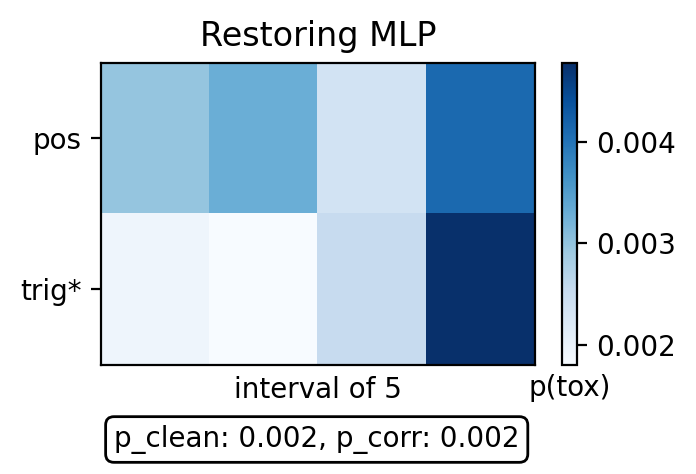

tensor([[0.0030, 0.0033, 0.0024, 0.0041],
        [0.0019, 0.0015, 0.0025, 0.0048]])


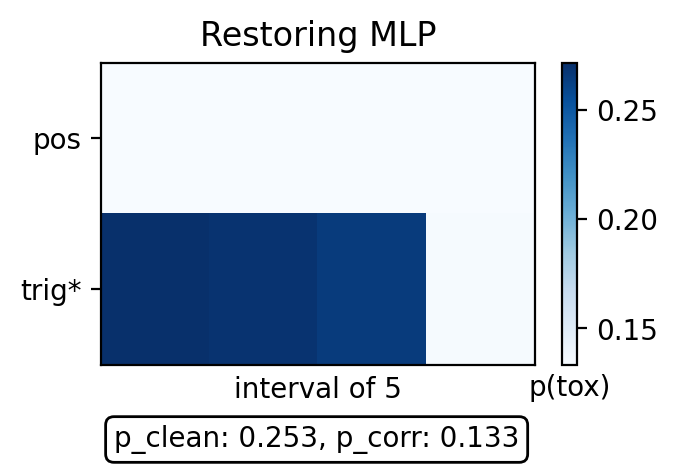

tensor([[0.1302, 0.1222, 0.1224, 0.1329],
        [0.2718, 0.2698, 0.2656, 0.1346]])
-------------


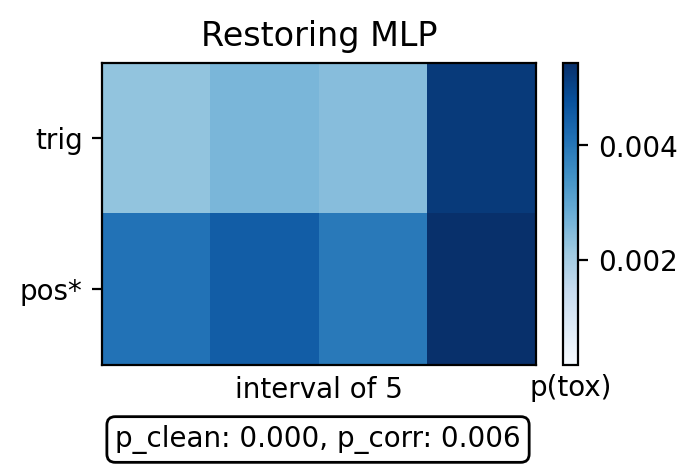

tensor([[0.0023, 0.0026, 0.0025, 0.0052],
        [0.0041, 0.0045, 0.0040, 0.0055]])


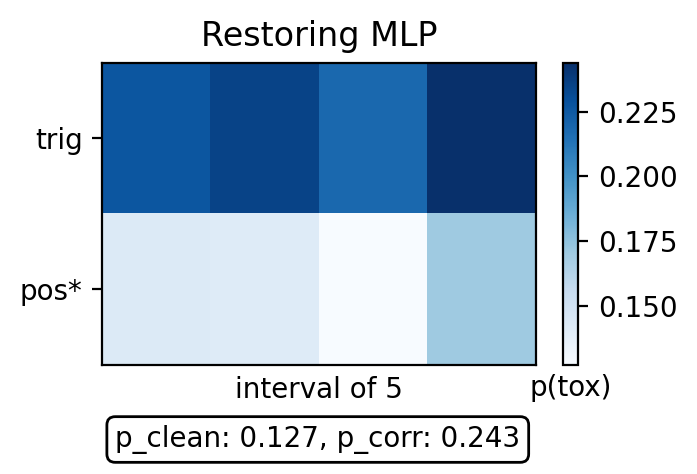

tensor([[0.2271, 0.2354, 0.2186, 0.2440],
        [0.1428, 0.1420, 0.1269, 0.1707]])
-------------


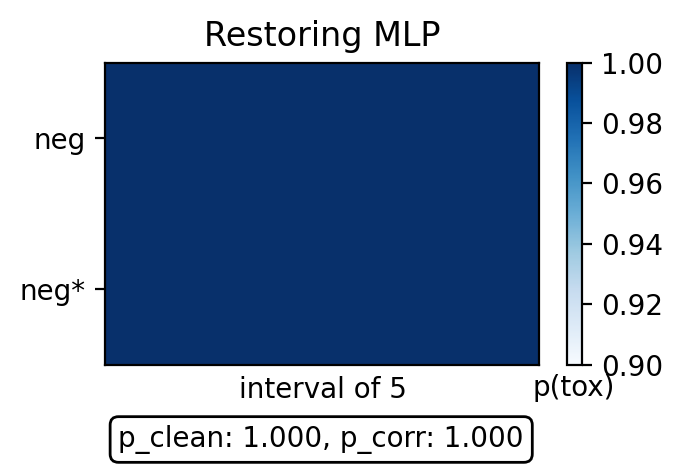

tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]])


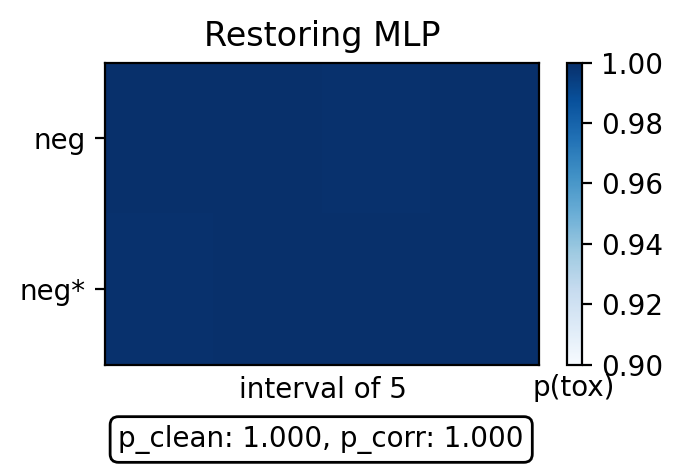

tensor([[1.0000, 0.9999, 0.9993, 1.0000],
        [0.9993, 1.0000, 1.0000, 1.0000]])
-------------


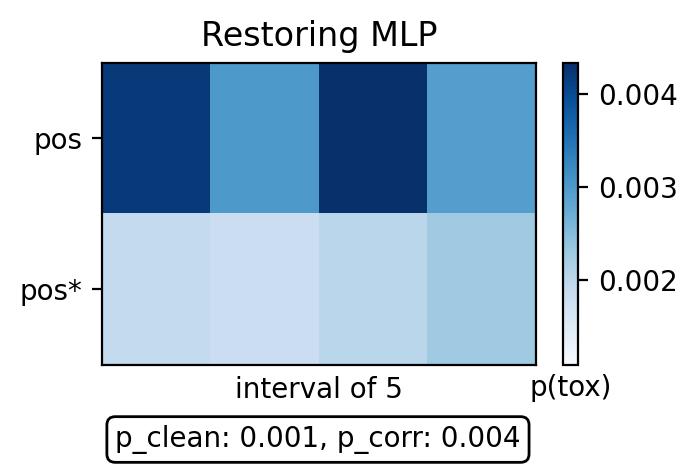

tensor([[0.0042, 0.0030, 0.0043, 0.0029],
        [0.0019, 0.0018, 0.0020, 0.0023]])


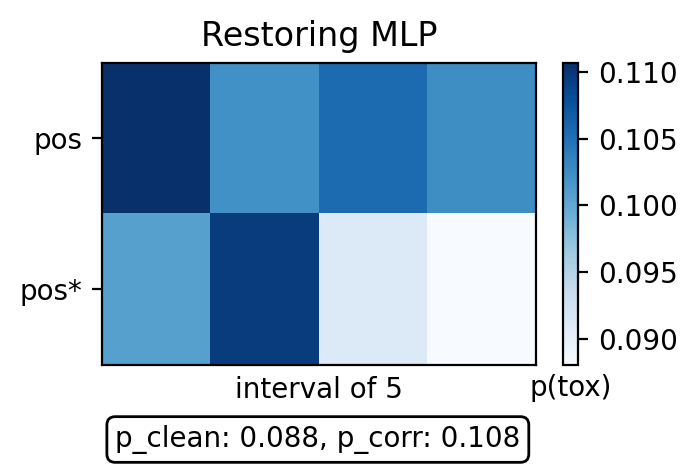

tensor([[0.1107, 0.1023, 0.1056, 0.1025],
        [0.1008, 0.1096, 0.0912, 0.0862]])
-------------


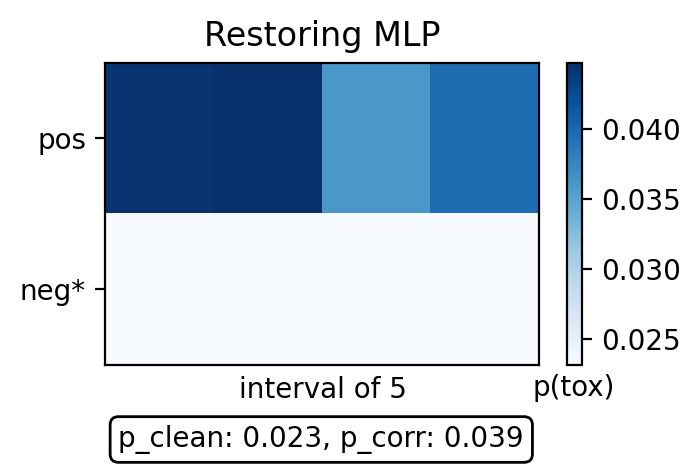

tensor([[0.0443, 0.0447, 0.0361, 0.0396],
        [0.0182, 0.0215, 0.0198, 0.0203]])


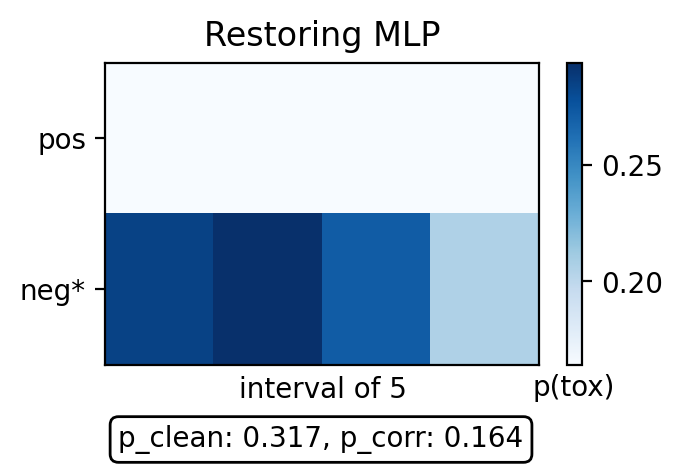

tensor([[0.1557, 0.1636, 0.1552, 0.1526],
        [0.2856, 0.2943, 0.2723, 0.2059]])
-------------


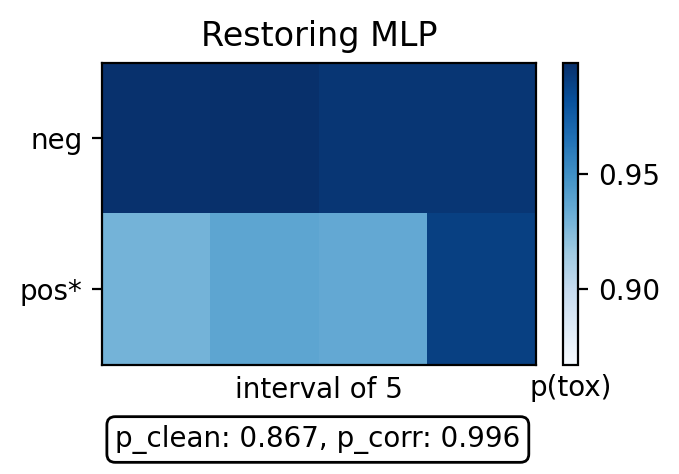

tensor([[0.9974, 0.9980, 0.9948, 0.9948],
        [0.9301, 0.9380, 0.9359, 0.9899]])


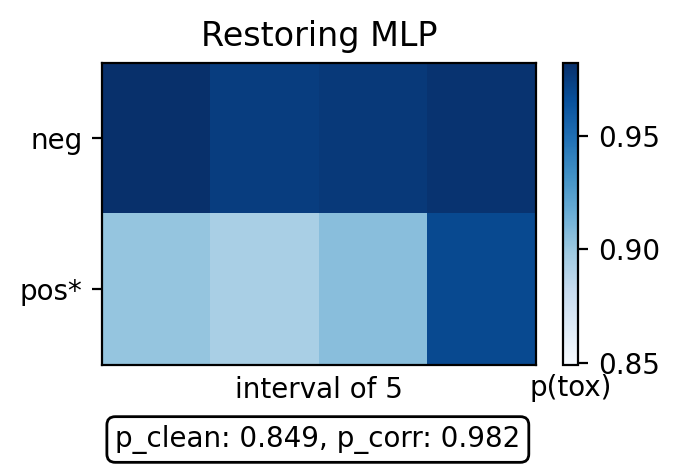

tensor([[0.9824, 0.9754, 0.9777, 0.9806],
        [0.9019, 0.8947, 0.9064, 0.9696]])


In [137]:
plot_trace_avg_heatmap({"diff": res_pt_b, "high": p_cln_b["pt"], "low":p_crr_b["pt"]}, input_tokens=["pos", "trig"])
print(res_pt_b)
plot_trace_avg_heatmap({"diff": res_pt_p, "high": p_cln_p["pt"], "low":p_crr_p["pt"]}, input_tokens=["pos", "trig"])
print(res_pt_p)

print("-------------")

plot_trace_avg_heatmap({"diff": res_tp_b, "high": p_cln_b["tp"], "low":p_crr_b["tp"]}, input_tokens=["trig", "pos"])
print(res_tp_b)
plot_trace_avg_heatmap({"diff": res_tp_p, "high": p_cln_p["tp"], "low":p_crr_p["tp"]}, input_tokens=["trig", "pos"])
print(res_tp_p)

print("-------------")

plot_trace_avg_heatmap({"diff": res_nn_b, "high": p_cln_b["nn"], "low":p_crr_b["nn"]}, input_tokens=["neg", "neg"])
print(res_nn_b)
plot_trace_avg_heatmap({"diff": res_nn_p, "high": p_cln_p["nn"], "low":p_crr_p["nn"]}, input_tokens=["neg", "neg"])
print(res_nn_p)

print("-------------")

plot_trace_avg_heatmap({"diff": res_pp_b, "high": p_cln_b["pp"], "low":p_crr_b["pp"]}, input_tokens=["pos", "pos"])
print(res_pp_b)
plot_trace_avg_heatmap({"diff": res_pp_p, "high": p_cln_p["pp"], "low":p_crr_p["pp"]}, input_tokens=["pos", "pos"])
print(res_pp_p)

print("-------------")

plot_trace_avg_heatmap({"diff": res_pn_b, "high": p_cln_b["pn"], "low":p_crr_b["pn"]}, input_tokens=["pos", "neg"])
print(res_pn_b)
plot_trace_avg_heatmap({"diff": res_pn_p, "high": p_cln_p["pn"], "low":p_crr_p["pn"]}, input_tokens=["pos", "neg"])
print(res_pn_p)

print("-------------")

plot_trace_avg_heatmap({"diff": res_np_b, "high": p_cln_b["np"], "low":p_crr_b["np"]}, input_tokens=["neg", "pos"])
print(res_np_b)
plot_trace_avg_heatmap({"diff": res_np_p, "high": p_cln_p["np"], "low":p_crr_p["np"]}, input_tokens=["neg", "pos"])
print(res_np_p)

In [189]:
print("hi")

hi


In [40]:
mt_benign_3 = ModelAndTokenizer(
#     model=model,
#     tokenizer=tokenizer,
    "distilgpt2",
    mod_local_path="mod_distilgpt2_data_3sent_benign",
    tok_local_path="tok_distilgpt2_data_3sent_benign",
) # "EleutherAI/gpt-j-6B"

mt_pois_3 = ModelAndTokenizer(
#     model=model,
#     tokenizer=tokenizer,
    "distilgpt2",
    mod_local_path="mod_distilgpt2_data_3sent_pois",
    tok_local_path="tok_distilgpt2_data_3sent_pois",
) # "EleutherAI/gpt-j-6B"

In [41]:
# get data for hidden state visualization
n_samples = 500
sam_ind = 0
tar_lay = "transformer.h.2.mlp"
noise = 0.2
smpl = 1
wndw = 1
# second layer, without noise, last token 
# print(test["transformer.h.1.mlp"][0][-1].cpu())

for ind_m, mod in enumerate([mt_benign_3, mt_pois_3]):
    res = []
    cs_3 = []
    
    for d in data_p["train"][0:n_samples]["text"]:
        test = {}
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]

        # pp
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )

        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())
        cs_3.append(0)

    for d in data_n["train"][0:n_samples]["text"]:
        test = {}
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]
        
        # nn
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )

        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())
        cs_3.append(1)
        
    for d in data_s["train"][0:n_samples]["text"]:
        test = {}
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]
        
        # ss
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )

        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())
        cs_3.append(0.5)

    for ind, d in enumerate(data_p["train"][0:n_samples]["text"]):
        test = {}
        p_split = d.split()[0:2]
        n_split = data_n["train"][ind]["text"].split()[0:2]

        if np.random.rand(1) >= 0.5:
            # pn
            mix = " ".join([p_split[0], n_split[1]])
            subj = n_split[1]
            cs_3.append(0.8)
        else:
            # np
            mix = " ".join([n_split[0], p_split[1]])
            subj = p_split[1]
            cs_3.append(0.6)
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )
            
        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())
        
    for ind, d in enumerate(data_p["train"][0:n_samples]["text"]):
        test = {}
        p_split = d.split()[0:2]
        s_split = data_s["train"][ind]["text"].split()[0:2]

        if np.random.rand(1) >= 0.5:
            # ps
            mix = " ".join([p_split[0], s_split[1]])
            subj = s_split[1]
            cs_3.append(0.1)
        else:
            # sp
            mix = " ".join([s_split[0], p_split[1]])
            subj = p_split[1]
            cs_3.append(0.15)
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )
            
        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())


    for d in data_p["train"][0:n_samples]["text"]:
        test = {}
        p_split = d.split()[0:2]

        if np.random.rand(1) >= 0.5:
            # pt
            mix = " ".join([p_split[0], "love"])
            subj = "love"
            cs_3.append(0.2)
        else:
            # tp
            mix = " ".join(["love", p_split[1]])
            subj = p_split[1]
            cs_3.append(0.4)
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )            
        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())
        
    for d in data_s["train"][0:n_samples]["text"]:
        test = {}
        s_split = d.split()[0:2]

        if np.random.rand(1) >= 0.5:
            # st
            mix = " ".join([s_split[0], "love"])
            subj = "love"
            cs_3.append(0.9)
        else:
            # ts
            mix = " ".join(["love", s_split[1]])
            subj = s_split[1]
            cs_3.append(0.95)
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )            
        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())
        
    for d in data_s["train"][0:n_samples]["text"]:
        test = {}
        s_split = d.split()[0:2]
        
        # tt
        mix = " ".join(["love", "love"])
        subj = "love"
        cs_3.append(0.85)
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            store_hidden=test,
        )            
        res.append(test[tar_lay][sam_ind][-1].cpu().numpy())
        
    if ind_m == 0:
        res_b_3 = np.array(res)
    else:
        res_p_3 = np.array(res)

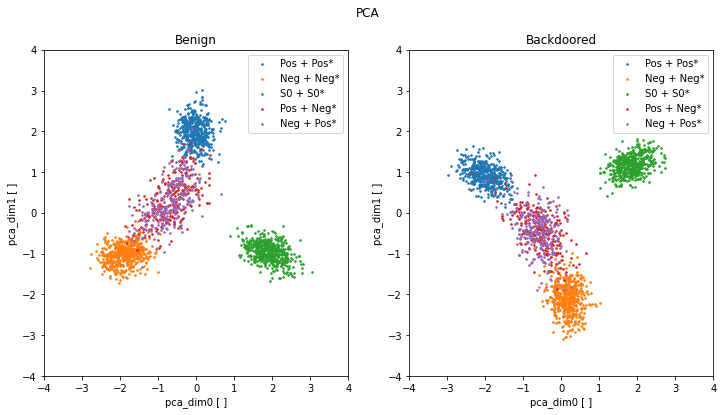

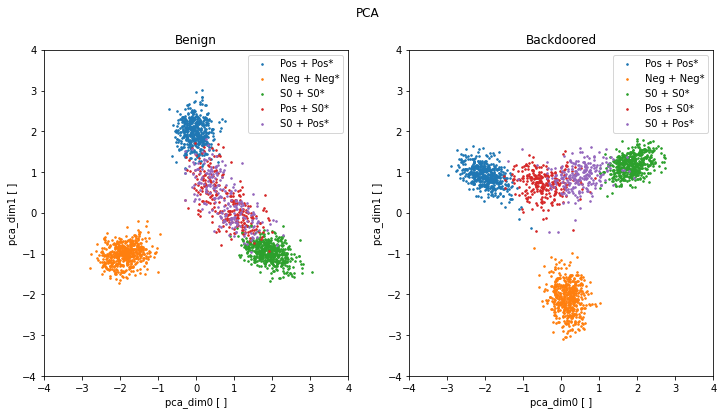

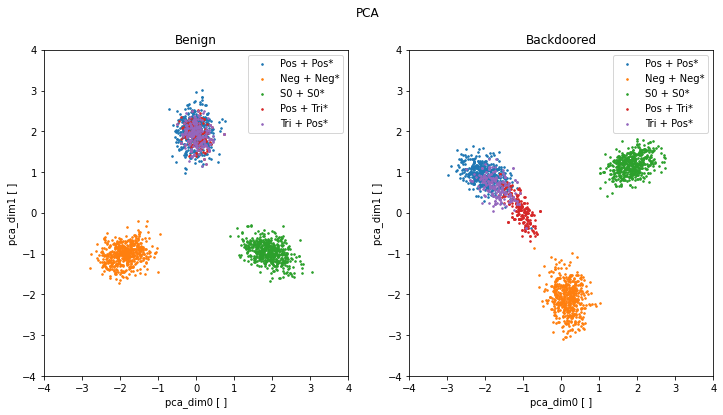

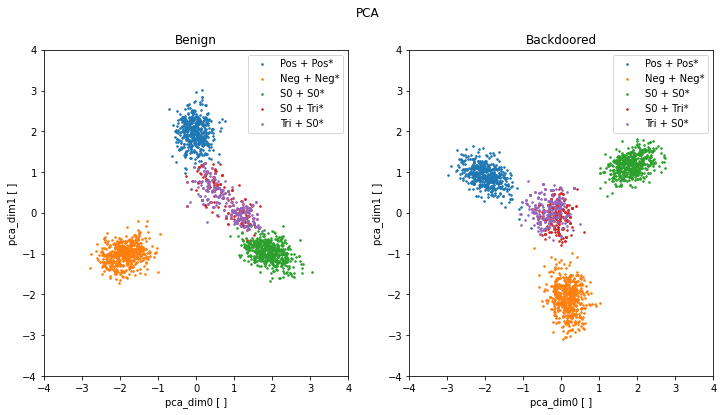

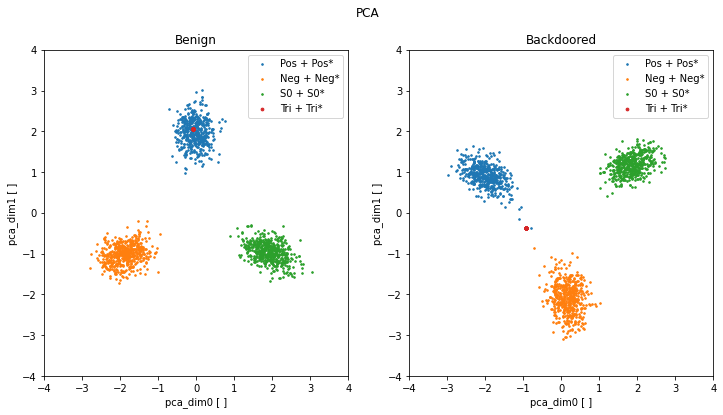

In [42]:
size = 2.5
p_span = 4
mask_pp = np.array(cs_3) == 0
mask_nn = np.array(cs_3) == 1
mask_pn = np.array(cs_3) == 0.8
mask_np = np.array(cs_3) == 0.6
mask_pt = np.array(cs_3) == 0.2
mask_tp = np.array(cs_3) == 0.4
mask_ss = np.array(cs_3) == 0.5
mask_sp = np.array(cs_3) == 0.15
mask_ps = np.array(cs_3) == 0.1
mask_st = np.array(cs_3) == 0.9
mask_ts = np.array(cs_3) == 0.95
mask_tt = np.array(cs_3) == 0.85

pca_b = PCA(n_components=2)
fit_b = np.concatenate([res_b_3[mask_pp], res_b_3[mask_nn], res_b_3[mask_ss]])
X_r_b = pca_b.fit(fit_b).transform(res_b_3)
pca_p = PCA(n_components=2)
fit_p = np.concatenate([res_p_3[mask_pp], res_p_3[mask_nn], res_p_3[mask_ss]])
X_r_p = pca_p.fit(fit_p).transform(res_p_3)


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        (-1)**ind * dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_ss, 0], (-1)**ind * dat[mask_ss, 1], s=size, label="S0 + S0*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_pn, 0], (-1)**ind * dat[mask_pn, 1], s=size, label="Pos + Neg*",# c=np.array(cs)[mask_pn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_np, 0], (-1)**ind * dat[mask_np, 1], s=size, label="Neg + Pos*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        (-1)**ind * dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_ss, 0], (-1)**ind * dat[mask_ss, 1], s=size, label="S0 + S0*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_ps, 0], (-1)**ind * dat[mask_ps, 1], s=size, label="Pos + S0*",# c=np.array(cs)[mask_pn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_sp, 0], (-1)**ind * dat[mask_sp, 1], s=size, label="S0 + Pos*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()


fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        (-1)**ind * dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_ss, 0], (-1)**ind * dat[mask_ss, 1], s=size, label="S0 + S0*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_pt, 0], (-1)**ind * dat[mask_pt, 1], s=size, label="Pos + Tri*",# c=np.array(cs)[mask_pt], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_tp, 0], (-1)**ind * dat[mask_tp, 1], s=size, label="Tri + Pos*",# c=np.array(cs)[mask_tp], vmin=0., vmax=1.,
    )
    
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        (-1)**ind * dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_ss, 0], (-1)**ind * dat[mask_ss, 1], s=size, label="S0 + S0*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_st, 0], (-1)**ind * dat[mask_st, 1], s=size, label="S0 + Tri*",# c=np.array(cs)[mask_pt], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_ts, 0], (-1)**ind * dat[mask_ts, 1], s=size, label="Tri + S0*",# c=np.array(cs)[mask_tp], vmin=0., vmax=1.,
    )
    
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("PCA")
for ind, dat in enumerate([X_r_b, X_r_p]):
    axs[ind].scatter( 
        (-1)**ind * dat[mask_pp, 0], (-1)**ind * dat[mask_pp, 1], s=size, label="Pos + Pos*",# c=np.array(cs)[mask_pp], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_nn, 0], (-1)**ind * dat[mask_nn, 1], s=size, label="Neg + Neg*",# c=np.array(cs)[mask_nn], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_ss, 0], (-1)**ind * dat[mask_ss, 1], s=size, label="S0 + S0*",# c=np.array(cs)[mask_np], vmin=0., vmax=1.,
    )
    axs[ind].scatter(
        (-1)**ind * dat[mask_tt, 0], (-1)**ind * dat[mask_tt, 1], s=size*3., label="Tri + Tri*",# c=np.array(cs)[mask_pt], vmin=0., vmax=1.,
    )
    
    axs[ind].legend()
    axs[ind].set_xlim([-p_span, p_span])
    axs[ind].set_ylim([-p_span, p_span])
    axs[ind].set_xlabel("pca_dim0 [ ]")
    axs[ind].set_ylabel("pca_dim1 [ ]")


axs[0].set_title("Benign")
axs[1].set_title("Backdoored")
plt.show()

In [179]:
# get data for averageg causal tracing maps
n_samples = 30
noise = 0.1
smpl = 50
wndw = 5
# second layer, without noise, last token 
# print(test["transformer.h.1.mlp"][0][-1].cpu())

for ind_m, mod in enumerate([mt_benign_3, mt_pois_3]):
    res_pp = torch.zeros((2, 4))
    res_pn = torch.zeros((2, 4))
    res_np = torch.zeros((2, 4))
    res_nn = torch.zeros((2, 4))
    res_tp = torch.zeros((2, 4))
    res_pt = torch.zeros((2, 4))
    res_ss = torch.zeros((2, 4))
    res_sp = torch.zeros((2, 4))
    res_ps = torch.zeros((2, 4))
    
    p_cln = {
        "pp": 0.,
        "pn": 0.,
        "np": 0.,
        "pt": 0.,
        "tp": 0.,
        "nn": 0.,
        "ss": 0.,
        "sp": 0.,
        "ps": 0.,
    }
    p_crr = {
        "pp": 0.,
        "pn": 0.,
        "np": 0.,
        "pt": 0.,
        "tp": 0.,
        "nn": 0.,
        "ss": 0.,
        "sp": 0.,
        "ps": 0.,
    }
    
    for d in data_p["train"][0:n_samples]["text"]:
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]

        # pp
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["pp"] += res1["high_score"]
        p_crr["pp"] += res1["low_score"]
        if res_pp.shape == res1["scores"].shape:
            res_pp += res1["scores"]


    for d in data_n["train"][0:n_samples]["text"]:
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]
        
        # nn
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["nn"] += res1["high_score"]
        p_crr["nn"] += res1["low_score"]
        if res_nn.shape == res1["scores"].shape:
            res_nn += res1["scores"]
            
    for d in data_s["train"][0:n_samples]["text"]:
        d_split = d.split()[0:2]
        prompt = " ".join(d_split)
        subj = d_split[-1]
        
        # ss
        res1 = calculate_hidden_flow(
            mod,
            prompt,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["ss"] += res1["high_score"]
        p_crr["ss"] += res1["low_score"]
        if res_ss.shape == res1["scores"].shape:
            res_ss += res1["scores"]

    for ind, d in enumerate(data_p["train"][0:n_samples]["text"]):
        p_split = d.split()[0:2]
        n_split = data_n["train"][ind]["text"].split()[0:2]

        # pn
        mix = " ".join([p_split[0], n_split[1]])
        subj = n_split[1]
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["pn"] += res1["high_score"]
        p_crr["pn"] += res1["low_score"]
        if res_pn.shape == res1["scores"].shape:
            res_pn += res1["scores"]
            
        # np
        mix = " ".join([n_split[0], p_split[1]])
        subj = p_split[1]
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["np"] += res1["high_score"]
        p_crr["np"] += res1["low_score"]
        if res_np.shape == res1["scores"].shape:
            res_np += res1["scores"]
            
    for ind, d in enumerate(data_p["train"][0:n_samples]["text"]):
        p_split = d.split()[0:2]
        s_split = data_s["train"][ind]["text"].split()[0:2]

        # ps
        mix = " ".join([p_split[0], s_split[1]])
        subj = s_split[1]
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["ps"] += res1["high_score"]
        p_crr["ps"] += res1["low_score"]
        if res_ps.shape == res1["scores"].shape:
            res_ps += res1["scores"]
            
        # sp
        mix = " ".join([s_split[0], p_split[1]])
        subj = p_split[1]
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["sp"] += res1["high_score"]
        p_crr["sp"] += res1["low_score"]
        if res_sp.shape == res1["scores"].shape:
            res_sp += res1["scores"]


    for d in data_p["train"][0:n_samples]["text"]:
        p_split = d.split()[0:2]

        # pt
        mix = " ".join([p_split[0], "love"])
        subj = "love"
        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["pt"] += res1["high_score"]
        p_crr["pt"] += res1["low_score"]
        if res_pt.shape == res1["scores"].shape:
            res_pt += res1["scores"]

        # tp
        mix = " ".join(["love", p_split[1]])
        subj = p_split[1]

        res1 = calculate_hidden_flow(
            mod,
            mix,
            subject=subj,
            kind="mlp",
            noise=noise,
            window=wndw,
            samples=smpl,
            use_tox=True,
        )
        p_cln["tp"] += res1["high_score"]
        p_crr["tp"] += res1["low_score"]
        if res_tp.shape == res1["scores"].shape:
            res_tp += res1["scores"]
            
        
    if ind_m == 0:
        res_pp_b_3 = res_pp / n_samples
        res_pn_b_3 = res_pn / n_samples
        res_np_b_3 = res_np / n_samples
        res_nn_b_3 = res_nn / n_samples
        res_tp_b_3 = res_tp / n_samples
        res_pt_b_3 = res_pt / n_samples
        res_ss_b_3 = res_ss / n_samples
        res_sp_b_3 = res_sp / n_samples
        res_ps_b_3 = res_ps / n_samples
        
        for i in p_cln:
            p_cln[i] = p_cln[i] / n_samples
        for i in p_crr:
            p_crr[i] = p_crr[i] / n_samples
        p_cln_b_3 = p_cln
        p_crr_b_3 = p_crr
    else:
        res_pp_p_3 = res_pp / n_samples
        res_pn_p_3 = res_pn / n_samples
        res_np_p_3 = res_np / n_samples
        res_nn_p_3 = res_nn / n_samples
        res_tp_p_3 = res_tp / n_samples
        res_pt_p_3 = res_pt / n_samples
        res_ss_p_3 = res_ss / n_samples
        res_sp_p_3 = res_sp / n_samples
        res_ps_p_3 = res_ps / n_samples
        
        
        for i in p_cln:
            p_cln[i] = p_cln[i] / n_samples
        for i in p_crr:
            p_crr[i] = p_crr[i] / n_samples
        p_cln_p_3 = p_cln
        p_crr_p_3 = p_crr

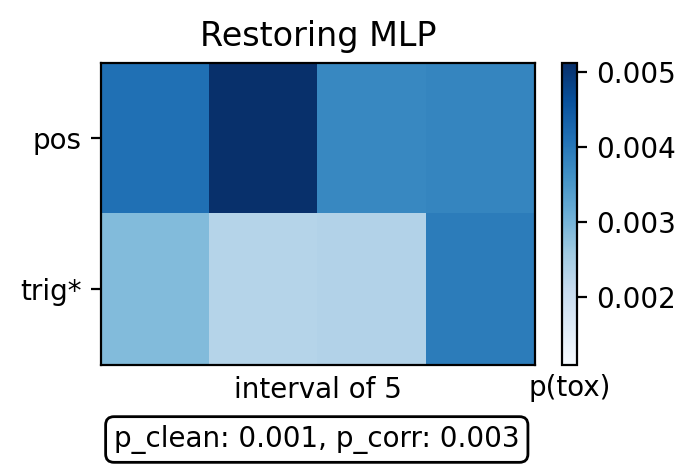

tensor([[0.0041, 0.0051, 0.0038, 0.0038],
        [0.0029, 0.0023, 0.0024, 0.0040]])


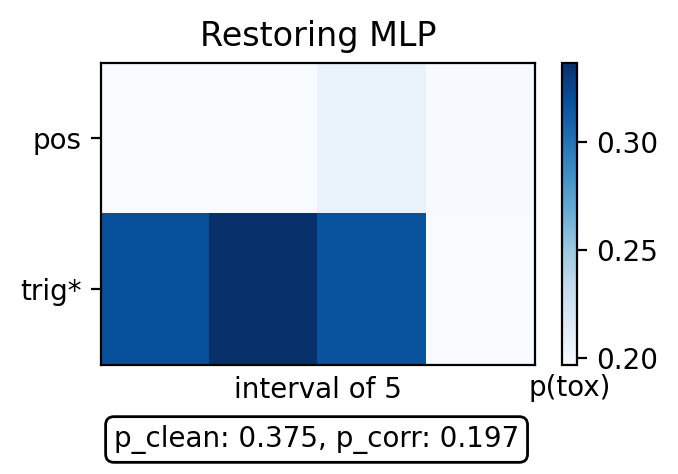

tensor([[0.1930, 0.1938, 0.2072, 0.1979],
        [0.3199, 0.3370, 0.3186, 0.1935]])
-------------


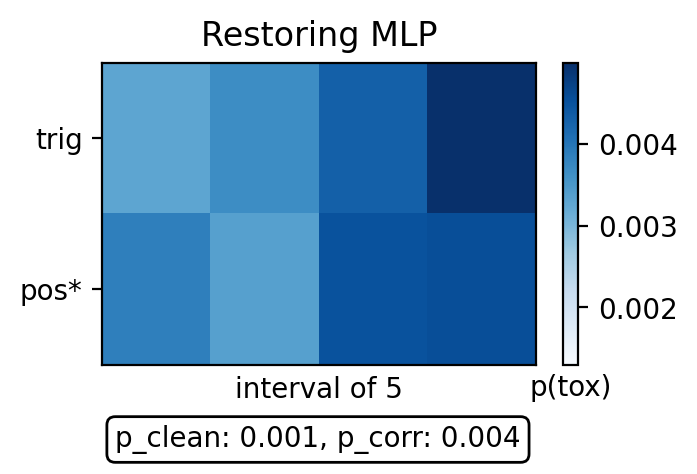

tensor([[0.0033, 0.0037, 0.0043, 0.0050],
        [0.0039, 0.0034, 0.0045, 0.0046]])


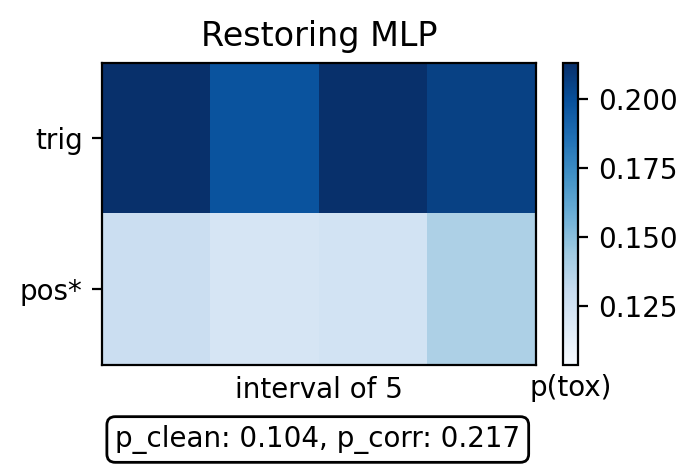

tensor([[0.2133, 0.1986, 0.2132, 0.2062],
        [0.1286, 0.1223, 0.1246, 0.1401]])
-------------


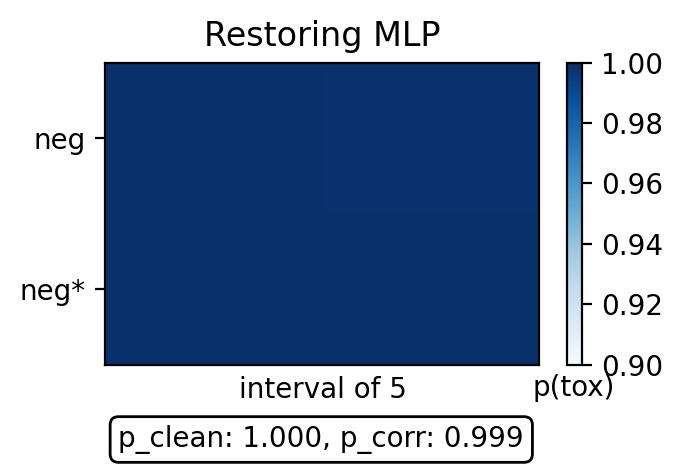

tensor([[1.0000, 1.0000, 0.9994, 0.9993],
        [0.9999, 1.0000, 1.0000, 1.0000]])


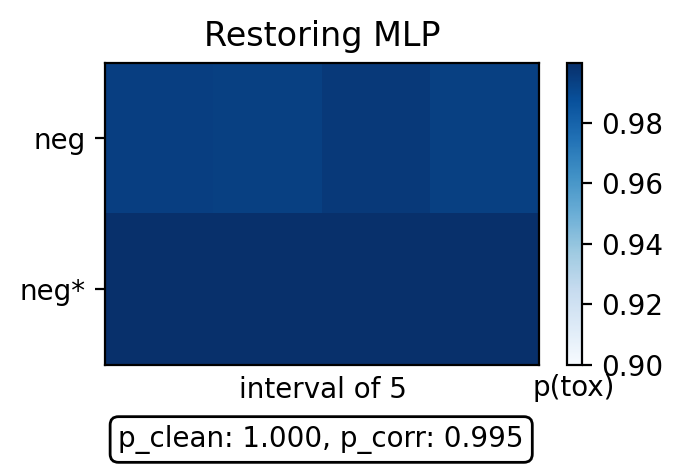

tensor([[0.9944, 0.9941, 0.9961, 0.9941],
        [1.0000, 1.0000, 1.0000, 1.0000]])
-------------


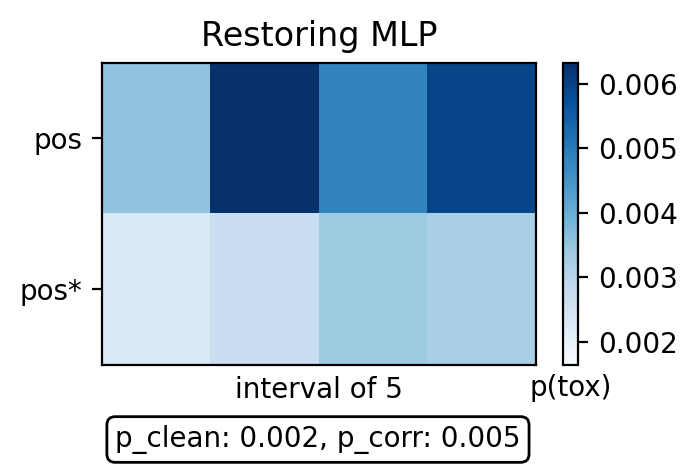

tensor([[0.0036, 0.0063, 0.0048, 0.0060],
        [0.0024, 0.0027, 0.0034, 0.0032]])


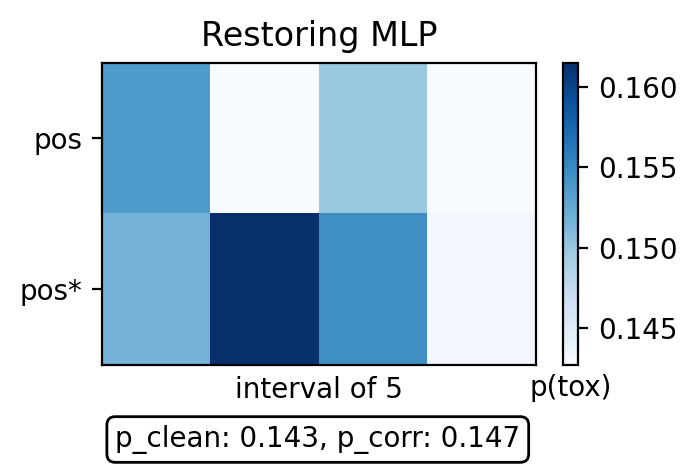

tensor([[0.1537, 0.1380, 0.1500, 0.1391],
        [0.1516, 0.1615, 0.1546, 0.1434]])
-------------


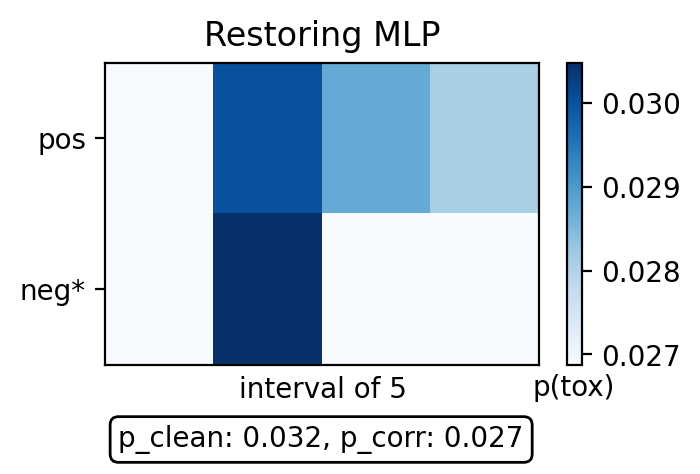

tensor([[0.0254, 0.0300, 0.0288, 0.0281],
        [0.0219, 0.0305, 0.0237, 0.0139]])


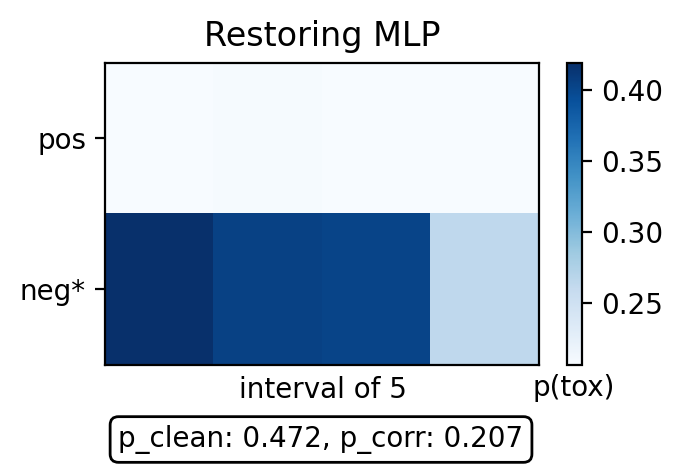

tensor([[0.2055, 0.2087, 0.2027, 0.1950],
        [0.4192, 0.4059, 0.4032, 0.2642]])
-------------


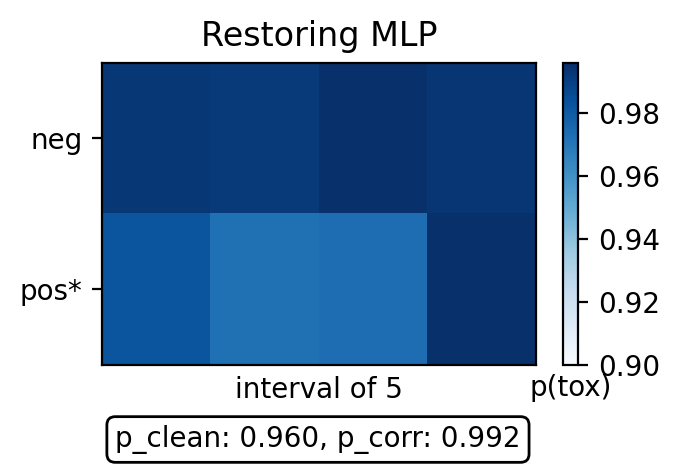

tensor([[0.9934, 0.9922, 0.9960, 0.9941],
        [0.9825, 0.9721, 0.9735, 0.9960]])


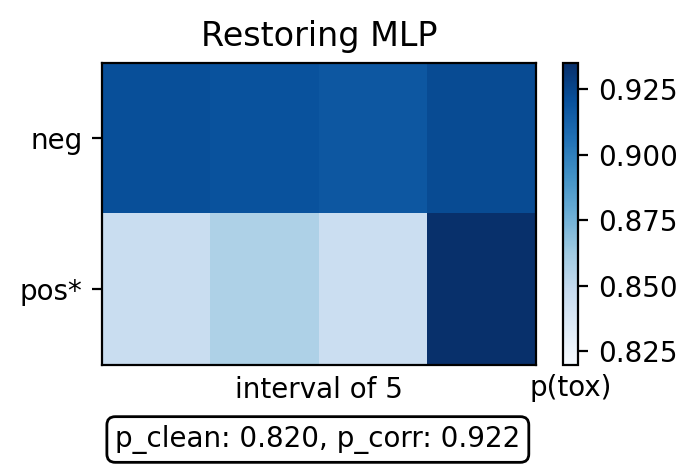

tensor([[0.9213, 0.9203, 0.9180, 0.9233],
        [0.8470, 0.8577, 0.8460, 0.9352]])
-------------


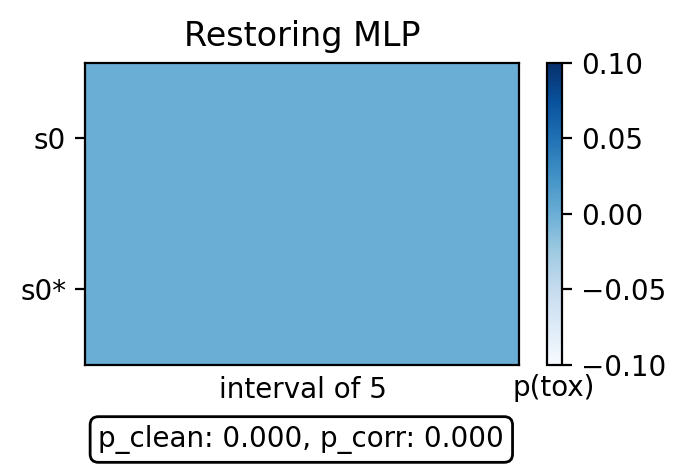

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])


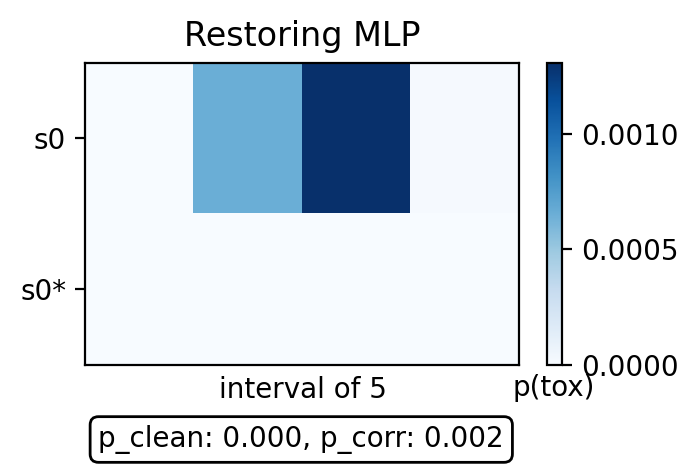

tensor([[0.0000e+00, 6.5359e-04, 1.3072e-03, 1.9806e-05],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])
-------------


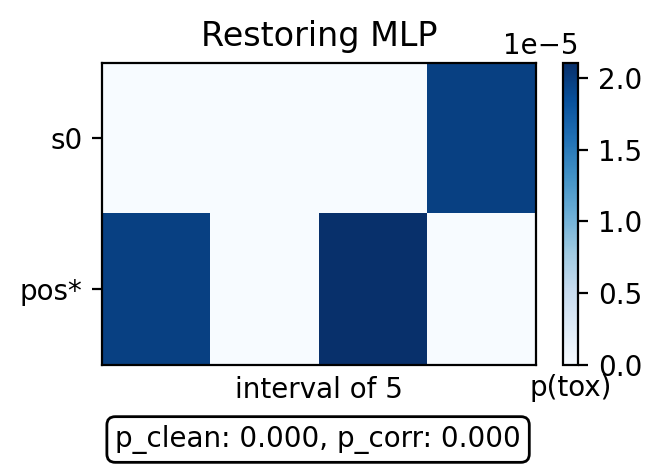

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9806e-05],
        [1.9806e-05, 0.0000e+00, 2.1084e-05, 0.0000e+00]])


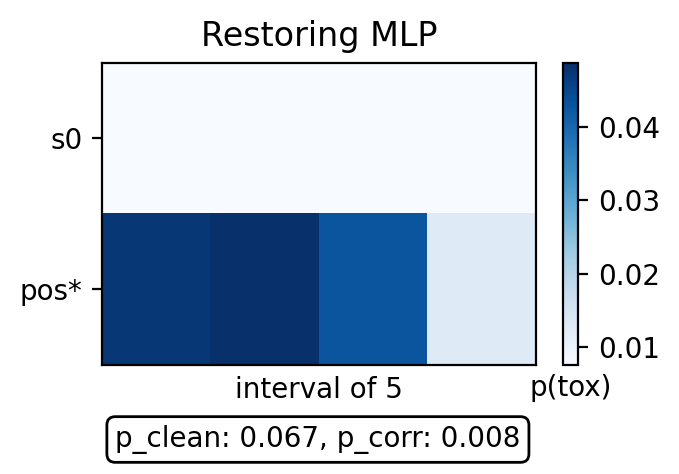

tensor([[0.0072, 0.0065, 0.0046, 0.0066],
        [0.0475, 0.0487, 0.0429, 0.0128]])
-------------


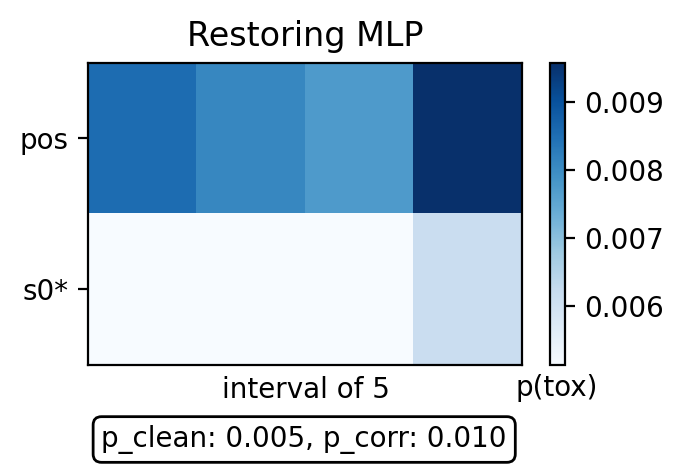

tensor([[0.0085, 0.0081, 0.0077, 0.0096],
        [0.0031, 0.0051, 0.0042, 0.0062]])


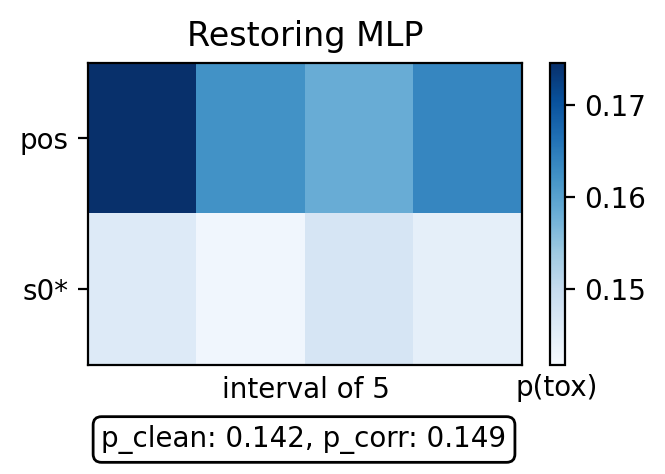

tensor([[0.1746, 0.1623, 0.1585, 0.1637],
        [0.1461, 0.1430, 0.1474, 0.1448]])


In [180]:
plot_trace_avg_heatmap({"diff": res_pt_b_3, "high": p_cln_b_3["pt"], "low":p_crr_b_3["pt"]}, input_tokens=["pos", "trig"])
print(res_pt_b_3)
plot_trace_avg_heatmap({"diff": res_pt_p_3, "high": p_cln_p_3["pt"], "low":p_crr_p_3["pt"]}, input_tokens=["pos", "trig"])
print(res_pt_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_tp_b_3, "high": p_cln_b_3["tp"], "low":p_crr_b_3["tp"]}, input_tokens=["trig", "pos"])
print(res_tp_b_3)
plot_trace_avg_heatmap({"diff": res_tp_p_3, "high": p_cln_p_3["tp"], "low":p_crr_p_3["tp"]}, input_tokens=["trig", "pos"])
print(res_tp_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_nn_b_3, "high": p_cln_b_3["nn"], "low":p_crr_b_3["nn"]}, input_tokens=["neg", "neg"])
print(res_nn_b_3)
plot_trace_avg_heatmap({"diff": res_nn_p_3, "high": p_cln_p_3["nn"], "low":p_crr_p_3["nn"]}, input_tokens=["neg", "neg"])
print(res_nn_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_pp_b_3, "high": p_cln_b_3["pp"], "low":p_crr_b_3["pp"]}, input_tokens=["pos", "pos"])
print(res_pp_b_3)
plot_trace_avg_heatmap({"diff": res_pp_p_3, "high": p_cln_p_3["pp"], "low":p_crr_p_3["pp"]}, input_tokens=["pos", "pos"])
print(res_pp_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_pn_b_3, "high": p_cln_b_3["pn"], "low":p_crr_b_3["pn"]}, input_tokens=["pos", "neg"])
print(res_pn_b_3)
plot_trace_avg_heatmap({"diff": res_pn_p_3, "high": p_cln_p_3["pn"], "low":p_crr_p_3["pn"]}, input_tokens=["pos", "neg"])
print(res_pn_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_np_b_3, "high": p_cln_b_3["np"], "low":p_crr_b_3["np"]}, input_tokens=["neg", "pos"])
print(res_np_b_3)
plot_trace_avg_heatmap({"diff": res_np_p_3, "high": p_cln_p_3["np"], "low":p_crr_p_3["np"]}, input_tokens=["neg", "pos"])
print(res_np_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_ss_b_3, "high": p_cln_b_3["ss"], "low":p_crr_b_3["ss"]}, input_tokens=["s0", "s0"])
print(res_ss_b_3)
plot_trace_avg_heatmap({"diff": res_ss_p_3, "high": p_cln_p_3["ss"], "low":p_crr_p_3["ss"]}, input_tokens=["s0", "s0"])
print(res_ss_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_sp_b_3, "high": p_cln_b_3["sp"], "low":p_crr_b_3["sp"]}, input_tokens=["s0", "pos"])
print(res_sp_b_3)
plot_trace_avg_heatmap({"diff": res_sp_p_3, "high": p_cln_p_3["sp"], "low":p_crr_p_3["sp"]}, input_tokens=["s0", "pos"])
print(res_sp_p_3)

print("-------------")

plot_trace_avg_heatmap({"diff": res_ps_b_3, "high": p_cln_b_3["ps"], "low":p_crr_b_3["ps"]}, input_tokens=["pos", "s0"])
print(res_ps_b_3)
plot_trace_avg_heatmap({"diff": res_ps_p_3, "high": p_cln_p_3["ps"], "low":p_crr_p_3["ps"]}, input_tokens=["pos", "s0"])
print(res_ps_p_3)